In [72]:
import pandas as pd
import numpy as np
import gzip
import itertools
import plotnine as p9
import datetime




In [73]:
gz_file = gzip.open('data/manipulation/ucdp_with_country.csv.gz', 'rb')

df = pd.read_csv(gz_file)
df.tail()

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,11,14,17,49,55) have mixed types.Specify dtype option on import or set low_memory=False.


,index,data_source,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,...,low,gwnoa,gwnob,high_amend,low_amend,nat_earth_country_name,method,flag,Country,Country.1
280250,1683,candidate_monthly,432843,NIG-2022-2-2-XXX475-9,2022,0,Check dyad,2,2-XXX475,119,...,2,NaN,NaN,2,2,Nigeria,Nearest,NaN,Nigeria,Nigeria
280251,1684,candidate_monthly,429461,UKR-2022-1-14117-20,2022,1,Check deaths,1,13243,13243,...,0,369.0,369.0,13,0,Ukraine,Nearest,NaN,Ukraine,Ukraine
280252,1685,candidate_monthly,430417,UKR-2022-1-14117-99,2022,1,Clear,1,13243,13243,...,2,369.0,369.0,2,2,Ukraine,Nearest,NaN,Ukraine,Ukraine
280253,1686,candidate_monthly,429506,UKR-2022-1-14117-32,2022,1,Clear,1,13243,13243,...,2,369.0,369.0,2,2,Ukraine,Nearest,NaN,Ukraine,Ukraine
280254,1687,candidate_monthly,430097,UKR-2022-1-14117-62.2,2022,1,Clear,1,13243,13243,...,4,369.0,369.0,4,4,Ukraine,Nearest,NaN,Ukraine,Ukraine


### Aggregate – annual

#### A note on conflict IDs

Conflicts can have more than one type of violence (within a single year)

In [74]:
df_test_agg = df.groupby(['conflict_new_id', 'year'])['type_of_violence'].nunique()
df_test_agg = df_test_agg.reset_index()
df_test_agg.loc[(df_test_agg.type_of_violence>1),].head()

,conflict_new_id,year,type_of_violence
3,22,2021,2
7,28,2021,2
9,35,2021,2
11,38,2022,2
13,55,2021,2


And that conflicts can take place in more than country (in a single year)

In [75]:
df_test_agg = df.groupby(['conflict_new_id', 'year'])['Country'].nunique()
df_test_agg = df_test_agg.reset_index()
df_test_agg.loc[(df_test_agg.Country>1),].head()

,conflict_new_id,year,Country
9,35,2021,2
17,85,2021,2
23,107,2021,2
26,118,2021,2
27,119,2021,2


That means that the number of conflicts broken down by place or type of conflict won't sum up to the global totals.

#### Aggregate broken down by type of violence

This is a function that, grouped by specified cols, sums over a range of cols and counts unique values over a range of cols.

In [76]:
def my_aggregation(df, cols_to_group_by):
    
    cols_to_sum = ['best', 'low_amend', 'high_amend']
    cols_to_count = 'conflict_new_id'
     
    # Sum deaths    
    df_deaths_agg = df.groupby(cols_to_group_by)[cols_to_sum].sum()
    df_deaths_agg = df_deaths_agg.reset_index()

    # Count conflicts   
    df_confl_agg = df.groupby(cols_to_group_by)[cols_to_count].nunique()
    df_confl_agg = df_confl_agg.reset_index()

    df_confl_agg.rename(columns = {"conflict_new_id":"number_of_conflicts"}, inplace = True)

    # Merge deaths and count together (merging on cols_to_group_by)
    df_agg = pd.merge(df_deaths_agg, df_confl_agg)
        
    return df_agg

Aggregate by type of violence and year and...

...by country

In [77]:
df_bytype_country_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['Country','type_of_violence', 'year']
    )

df_bytype_country_agg.rename(columns = {"Country":"entity"}, inplace = True)

df_bytype_country_agg.head()

,entity,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts
0,Afghanistan,1,1989,5174,1883,17074,1
1,Afghanistan,1,1990,1478,1322,2276,1
2,Afghanistan,1,1991,3302,3156,3802,1
3,Afghanistan,1,1992,4287,4270,5471,1
4,Afghanistan,1,1993,4071,4043,8205,2


...by region (according to UCDP region definitions)

In [78]:
df_bytype_region_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['region','type_of_violence', 'year']
    )

df_bytype_region_agg.rename(columns = {"region":"entity"}, inplace = True)

df_bytype_region_agg.head()

,entity,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts
0,Africa,1,1989,34546,34516,47458,13
1,Africa,1,1990,64847,62499,78847,15
2,Africa,1,1991,25510,23653,35629,19
3,Africa,1,1992,6922,6814,23260,17
4,Africa,1,1993,15091,15084,27250,14


.. for world total

In [79]:
df_bytype_world_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['type_of_violence', 'year']
    )

df_bytype_world_agg['entity'] = "World"

df_bytype_world_agg.head()

,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts,entity
0,1,1989,54414,50204,84565,50,World
1,1,1990,80023,76816,97591,55,World
2,1,1991,70364,68075,91497,58,World
3,1,1992,50160,46702,75324,65,World
4,1,1993,37147,36204,59363,57,World


#### Aggregate over all conflict types

In [80]:
df_alltype_country_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['Country', 'year']
    )

df_alltype_country_agg.rename(columns = {"Country":"entity"}, inplace = True)

df_alltype_country_agg['type_of_violence'] = 999 # code for 'all types'

df_alltype_country_agg.head()

,entity,year,best,low_amend,high_amend,number_of_conflicts,type_of_violence
0,Afghanistan,1989,5411,2120,17665,3,999
1,Afghanistan,1990,1514,1358,2312,2,999
2,Afghanistan,1991,3553,3407,4053,3,999
3,Afghanistan,1992,4385,4368,5865,3,999
4,Afghanistan,1993,4105,4077,8453,4,999


...by region (according to UCDP region definitions)

In [81]:
df_alltype_region_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['region','year']
    )

df_alltype_region_agg.rename(columns = {"region":"entity"}, inplace = True)

df_alltype_region_agg['type_of_violence'] = 999 # code for 'all types'

df_alltype_region_agg.head()

,entity,year,best,low_amend,high_amend,number_of_conflicts,type_of_violence
0,Africa,1989,40608,40576,60459,38,999
1,Africa,1990,72844,70226,90004,51,999
2,Africa,1991,33926,31923,46652,67,999
3,Africa,1992,18881,18225,41369,79,999
4,Africa,1993,30714,27801,49991,80,999


.. for world total

In [82]:
df_alltype_world_agg = my_aggregation(
    df = df,
    cols_to_group_by = ['year']
    )

df_alltype_world_agg['entity'] = "World"

df_alltype_world_agg['type_of_violence'] = 999 # code for 'all types'


df_alltype_world_agg.head()

,year,best,low_amend,high_amend,number_of_conflicts,entity,type_of_violence
0,1989,66691,60266,107761,126,World,999
1,1990,95311,90986,120096,149,World,999
2,1991,84140,81178,110152,155,World,999
3,1992,72606,68206,107302,192,World,999
4,1993,55886,51847,89682,183,World,999


Append aggregate dfs together

In [83]:
frames = [df_bytype_country_agg, df_bytype_region_agg, df_bytype_world_agg,\
          df_alltype_country_agg, df_alltype_region_agg, df_alltype_world_agg]

df_agg = pd.concat(frames)
df_agg.head()

,entity,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts
0,Afghanistan,1,1989,5174,1883,17074,1
1,Afghanistan,1,1990,1478,1322,2276,1
2,Afghanistan,1,1991,3302,3156,3802,1
3,Afghanistan,1,1992,4287,4270,5471,1
4,Afghanistan,1,1993,4071,4043,8205,2


Rename variables and restructure for grapher

In [84]:
type_text = {1: "State-based conflict",
             2: "Non-state conflict",
             3: "One-sided violence",
             999: "All types of organised violence"}

df_agg = df_agg.replace(dict(type_of_violence = type_text))

df_agg.head()

,entity,type_of_violence,year,best,low_amend,high_amend,number_of_conflicts
0,Afghanistan,State-based conflict,1989,5174,1883,17074,1
1,Afghanistan,State-based conflict,1990,1478,1322,2276,1
2,Afghanistan,State-based conflict,1991,3302,3156,3802,1
3,Afghanistan,State-based conflict,1992,4287,4270,5471,1
4,Afghanistan,State-based conflict,1993,4071,4043,8205,2


### Merge in a complete grid of entity-years to add 'zeros' for entity years where no events occurred.

Load the country mapping file – this gives a list of all countries in the Natural Earth low res shapefile, mapped to OWID names.

In [85]:
mapping = pd.read_csv('data/countries/country_names_low_res_country_standardized.csv')
mapping.head()

,Country,Our World In Data Name
0,Fiji,Fiji
1,Tanzania,Tanzania
2,W. Sahara,Western Sahara
3,Canada,Canada
4,United States of America,United States


Get a list of regions used in UCDP

In [86]:
UCDP_regions = df.region.unique()

In [87]:
def expand_grid(data_dict):
    """Create a dataframe from every combination of given values."""
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())

In [88]:
grid = expand_grid(
   .....:    {'entity':np.concatenate((mapping["Our World In Data Name"], UCDP_regions, ["World"])),
   .....:     'year': range(1989, 2023),
   .....:     'type_of_violence': df_agg.type_of_violence.unique()})

In [89]:
grid.tail()

,entity,year,type_of_violence
24883,World,2021,All types of organised violence
24884,World,2022,State-based conflict
24885,World,2022,Non-state conflict
24886,World,2022,One-sided violence
24887,World,2022,All types of organised violence


Merge in actual UCDP data to empty grid (this creates NaNs for missing rows)

In [90]:
df_agg = pd.merge(grid, df_agg, how='left')

In [91]:
df_agg.head()

,entity,year,type_of_violence,best,low_amend,high_amend,number_of_conflicts
0,Fiji,1989,State-based conflict,NaN,NaN,NaN,NaN
1,Fiji,1989,Non-state conflict,NaN,NaN,NaN,NaN
2,Fiji,1989,One-sided violence,NaN,NaN,NaN,NaN
3,Fiji,1989,All types of organised violence,NaN,NaN,NaN,NaN
4,Fiji,1990,State-based conflict,NaN,NaN,NaN,NaN


Replace NaN with zeros

In [92]:
df_agg[['best', 'low_amend', 'high_amend', 'number_of_conflicts']] = df_agg[['best', 'low_amend', 'high_amend', 'number_of_conflicts']].fillna(0)

### Aggregate daily

Look at the distribution of length of events in number of days

In [53]:

df[['date_start','date_end']] = df[['date_start','date_end']].apply(pd.to_datetime) # convert to date format

df['event_duration_days'] = (df['date_end'] - df['date_start']).dt.days + 1



pd.DataFrame(np.unique(df['event_duration_days'], return_counts=True))



,0,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,1,2,3,4,5,6,7,8,9,10,...,356,357,360,361,362,363,364,365,366,396
1,237995,20066,7243,1886,1015,752,1896,702,278,296,...,1,3,1,1,4,4,2,579,147,1


In [ ]:
df.hist(column='event_duration_days', bins = 100)

### Visual sense check

In [97]:
select_countries = ["Ukraine", "United States"]
select_types = ["All types of organised violence"]
select_deaths_var = "best"

df_filter = df_agg[df_agg.entity.isin(select_countries)]
df_filter = df_filter[df_filter.type_of_violence.isin(select_types)]



In [98]:
df_filter

,entity,year,type_of_violence,best,low_amend,high_amend,number_of_conflicts
547,United States,1989,All types of organised violence,0.0,0.0,0.0,0.0
551,United States,1990,All types of organised violence,0.0,0.0,0.0,0.0
555,United States,1991,All types of organised violence,0.0,0.0,0.0,0.0
559,United States,1992,All types of organised violence,0.0,0.0,0.0,0.0
563,United States,1993,All types of organised violence,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
15351,Ukraine,2018,All types of organised violence,243.0,167.0,261.0,1.0
15355,Ukraine,2019,All types of organised violence,234.0,149.0,238.0,1.0
15359,Ukraine,2020,All types of organised violence,195.0,92.0,248.0,1.0
15363,Ukraine,2021,All types of organised violence,210.0,169.0,222.0,2.0


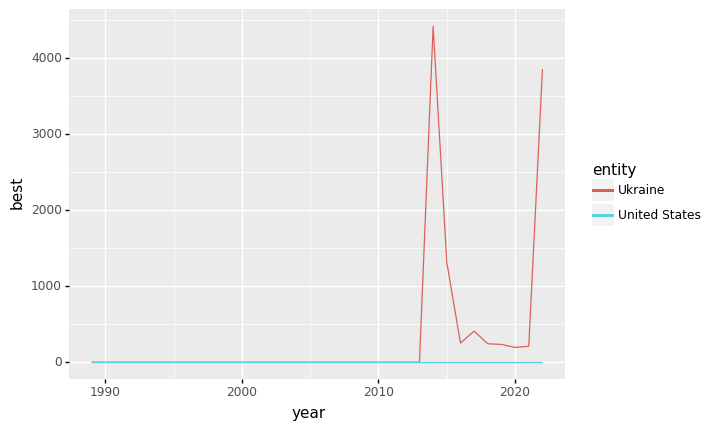

<ggplot: (395477011)>

In [99]:
(p9.ggplot(data=df_filter,
          mapping=p9.aes(x='year',y=select_deaths_var, colour = 'entity'))
     + p9.geom_line()
)

## Write to csv

In [100]:
df_agg.to_csv('data/output/ucdp_geolocated_data.csv.gz', index = False, compression = "gzip")